Assignment 2 - CMPT 419 Spring 2022

Name: Nicole Vavrukh

### Prelude: Importing Libraries

In [110]:
import pandas as pd # https://pandas.pydata.org/
import numpy as np # https://numpy.org/
import matplotlib.pyplot as plt # https://matplotlib.org/

# https://scikit-learn.org/stable/
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

___

## Part 1. Visualizing Unlabeled Training Data.

(Used [Towards Data Science](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) for coding help.)

In this notebook, some unknown and unlabeled static image data will be visualized. The OpenFace API has generated data regarding these images in a .csv with information such as Action Units (AUs), and both eye location and gaze direction. Taking this data, we will plot the n > 2 features in a 2D graph using Principal Component Analysis (PCA) and analyze to see what emotion these individuals could be experiencing or displaying for the camera.

In [111]:
# Import data using relative pathing
path = "unlabeled.csv"
df = pd.read_csv(path, index_col=0)

This .csv file has some data that will not be useful for our visualization, and so must be removed. We want to only have data that will help establish emotions.
Such data includes:
* Confidence
* Filename

We will also remove the binary data regarding AUs, which are stored as *AUXX_c*. While these are helpful, they are redundant with the presence of *AUXX_r*, which holds the intensity of the AU from 0-5, with 0 being "not present". In essence, *AUXX_r* does *AUXX_c*'s job, but with more nuance by tracking intensity. 

If we were to leave the duplicates, our PCA may become muddled, and we want to reduce as many dimensions as possible without removing information. This fixes both problems.

We are also excluding eye location data, as any part of the eye location data that is important will also be stored in our AUs, such as AU4, AU5, AU6, AU7, and AU45. Similarly, *Gaze_Angle* stores the individual eye gazes values in a simple radian format, condensing the 6 features into 2, as described in the OpenFace documentation.

*Gaze_Angle* is important because it is theorized that gaze direction corresponds to a given emotion being felt This is known as the [Shared Signal Hypothesis (SSH)](https://www.frontiersin.org/articles/10.3389/fpsyg.2021.684357/full). Gazes are generally put into 2 categories: 
* Direct gazes share an approach-orientated signal (ie Joy, Anger) 
* Averted gazes share an avoidance-orientated signal (ie Fear, Sadness)


In [112]:
# Removing unimportant data columns, pre-processing for PCA
x = df.drop(['confidence', 'filename', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU45_c'], axis=1)

# Isolate Important AUs and Gaze data
AUs = x.loc[:,x.columns.str.startswith('AU')]
GazeAngle = x.loc[:,x.columns.str.startswith('gaze_angle')]

# Merge content and store columns names for analysis
x = pd.concat([AUs, GazeAngle], axis = 1)
xColumns = x.columns

# Standardize the data to have a mean of approxiamtely 0 and a variance of around 1
x = StandardScaler().fit_transform(x)

It has requested that the data be presented in a 2D format, which means we may lose some information compared to 3D, but PCA maximizes the variability of the components, with the first having the most, the second having the second-most, etc. 

In [113]:
# Use PCA to plot data in 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

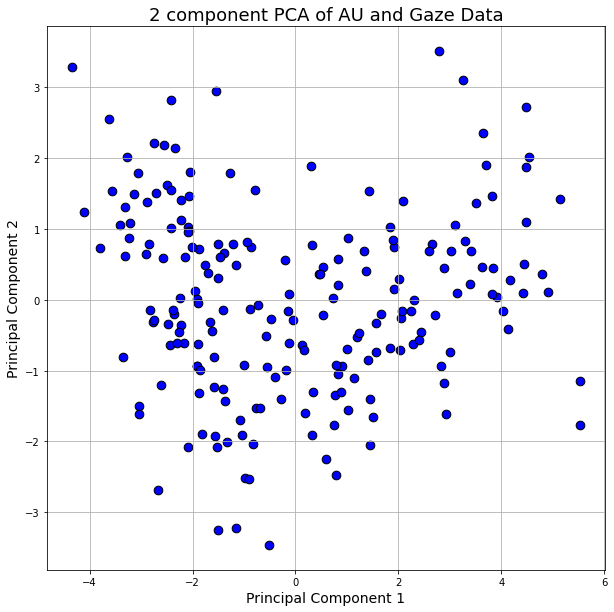

In [114]:
# Plot Axis
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot() 
ax.set_xlabel('Principal Component 1', fontsize = 14)
ax.set_ylabel('Principal Component 2', fontsize = 14)
ax.set_title('2 component PCA of AU and Gaze Data', fontsize = 18)

# Plot points into PCA Scatter Graph
ax.scatter(principalDf.loc[:,'principal component 1'], principalDf.loc[:,'principal component 2'], c = "blue", s = 75, edgecolors= "black")
ax.grid()

When analyzing data, is it important to see how information much we truly preserved. The explained variance ratio of the 2 components will show how much we preserved. The closer to 100% the ratio is, the more of the original data was preserved by the Principal Component.

The Eigenvalues for Explained Variance have also been included for knowledge's sake.

In [115]:
# Print Variance for PC1
print(f"Explained Variance for Component 1 = {pca.explained_variance_[0]:.2f}")
print(f"Explained Variance Percentage for Component 1 =  {(pca.explained_variance_ratio_[0] * 100):.2f}%\n")

# Print Variance for PC2
print(f"Explained Variance for Component 2 = {pca.explained_variance_[1]:.2f}")
print(f"Explained Variance Percentage for Component 2 = {(pca.explained_variance_ratio_[1] * 100):.2f}%\n")

# Print Total Variance Ratio for PCA
print(f"Total Explained Variance Percentage for Component 2 = {(pca.explained_variance_ratio_[1] * 100 + pca.explained_variance_ratio_[0] * 100):.2f}%")

Explained Variance for Component 1 = 5.84
Explained Variance Percentage for Component 1 =  29.05%

Explained Variance for Component 2 = 1.73
Explained Variance Percentage for Component 2 = 8.62%

Total Explained Variance Percentage for Component 2 = 37.66%


As seen above, we only preserved ~38% of our original data. This is not very good but was somewhat expected, as our 20 AUs and our gaze data were condensed into 2 components. Emotions consist of a subset of AUs, but said subsets are quite small (2-5 AUs), as seen [here](https://imotions.com/blog/facial-action-coding-system/). By condensing the AUs into only 2 components, some spectrum of emotions/AUs were bound to be missed. This also means that it is possible the context clues given by *Gaze_Angle* could also be lost. If we had decided to focus on specific AUs instead, we likely would have preserved more information regarding the specific AUs, but lost **all** information regarding the removed AUs. As we are unsure of the expressions being presented, it is simply safer to include all possible AUs to determine expressions. 

But which AUs are most influential to each Principal Component? If that is identified, what the components represent could also be identified. With that, the data and the corresponding images can be classified into expressions and/or emotions. To do so, we plot a biplot:

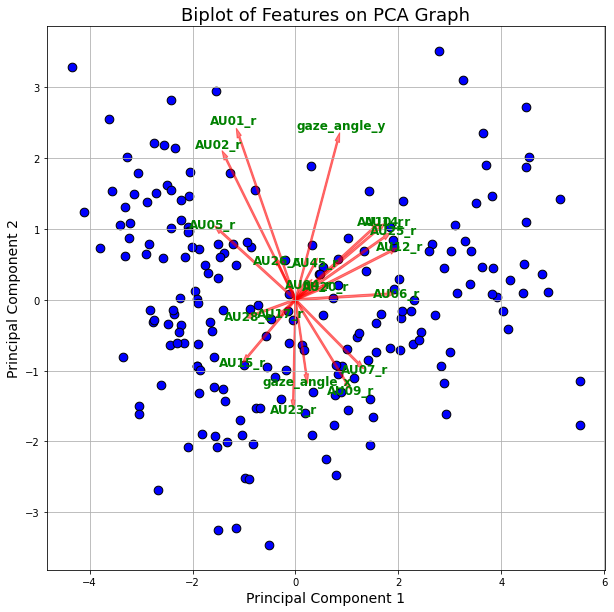

In [116]:
# Examining Eigenvalues to see which features are most important in PC1 and PC2 
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

# Source Code: https://stackoverflow.com/questions/57340166/how-to-plot-the-pricipal-vectors-of-each-variable-after-performing-pca

# Set up Plotting and Axis
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot() 
ax.set_xlabel('Principal Component 1', fontsize = 14)
ax.set_ylabel('Principal Component 2', fontsize = 14)
ax.set_title('Biplot of Features on PCA Graph', fontsize = 18)
plt.grid()

# Plot points into scatter
ax.scatter(principalDf.loc[:,'principal component 1'], principalDf.loc[:,'principal component 2'], c = "blue", s = 75, edgecolors= "black")

# Plot Features into Graph
coeff = pca.components_.T
n = coeff.shape[0] 
arrow_size = 0.03
dist = 5
for i in range(n):
    plt.arrow(0, 0, coeff[i,0]*dist, coeff[i,1]*dist,color = 'r',alpha = 0.5, width = arrow_size, head_width = 3 * arrow_size)
    plt.text(coeff[i,0]* (dist + 0.5), coeff[i,1] * (dist + 0.5), xColumns[i], color = 'g', ha = 'center', va = 'center', fontsize = 12, weight="bold")

plt.show()

The red vectors represent the original features the Principal Components were established from. The larger the vector, the more variability (and thus information) was preserved of that feature. Vectors close to each other are positively correlated to each other, whilst opposing vectors are negatively correlated. The orientation of the vectors also illustrates the contribution of that feature to the Principal Components; the more parallel it is to the component, the more it contributed to it specifically. We will use this to analyze what our Principal Components truly mean later.

### Sumary and Discussion

In summary, given our data of the image dataset, the features used to create our PCA were: Gaze_Angle and AUXX_r, as they were the most relevant to identifying emotions. As requested, the PCA was plotted in 2 dimensions. It was found that our PCA only had a total variance explained ratio of ~38%, meaning that over 50% of our original information was lost in the process. This was expected, as approximately 20 features were given to PCA to condense into 2 components. 

Using a biplot, we can try to identify the most important features of the Principal Components, which will help identify what emotions the images are showing. As mentioned above, this can be done by examining the vectors in the biplot. In general, as small vectors mean much data was lost, the focus will be on the larger vectors in the biplot.

**For Component 1:** *AU06_r* is very positively correlated to only PC1. *AU12_r*, *AU25_r* and *AU14_r* and *AU10_r* are all very correlated, and are also quite positively correlated to PC1. *AU07_r* and *AU09_r* are also positively correlated with PC1. *AU05_r* and *AU15_r* are slightly negatively correlated with PC1. 

AU06 (Cheek Raiser) and AU12 (Lip Corner Puller) are known to be signals for happiness, and they are the most positively correlated to PC1 exclusively. AU25 (Lips Part) may indicate that, when paired with AU12, the smile is with the mouth slightly open. AU14 (Dimpler) and AU10 (Upper Lip Raiser) are extremely correlated and must be examined together due to this; while AU14 is associated with contempt, with AU10 is such close association it may be a forced smile for the camera as the upper lip is raised to approximate a smile when they do not truly feel happy. Lastly, AU05 (Upper Lid Raiser) and AU15 (Lip Corner Depressor)'s negative correlations to PC1 match with PC1 being a happiness scale, as AU5 and AU15 are often found to prototypical negative emotions such as: Surprise, Fear, Disgust, and Sadness.

**For Component 2:** The Gaze_Angles are very strongly correlated to PC2—*Angle_x* being negatively, and *Angle_y* positively. *AU01_r* and *AU02_r* are positively correlated with each other and also highly positively correlated to PC2. *AU23_r* is exclusively highly negatively correlated with PC2. *AU05_r* is somewhat positively correlated, but *AU05_r* negatively. *AU09_r* is also negatively correlated. *AU07_r* and *AU09_r* are also positively correlated with PC1.

AU23 (Lip Tightener) is often associated with anger, but can indicate different things alone. AU07 (Lid Tightener) and AU09 (Nose Wrinkler) are also negatively correlated and show Disgust or Anger. AU01 (Inner Brow Raiser) and AU02 (Outer Brow Raiser) together form either a sign of Surprise or Fear. In terms of Gaze_Angle, looking down was a high positive correlation, while looking to the side was a negative correlation. If we tie PC2 to an emotion, it would likely have to be negative and would not work with the knowledge of PC1. 

Examining the data and applicable AUs, we see a pattern forming: PC1 is related to mouth action units, with higher PC1 values corresponding to smiles, and lower values to open frowning mouth positions. PC2 on the other hand is all about eyes. While not all AUs affecting PC2 are only eye-based they are related. (AU23) Lip Tightening is often paired with tightening of eyelids in facial expressions, and nose wrinkling was found to be strongly correlated to tightening of eyelids in the biplot itself. This even matches with the gaze angles having a large correlation to PC2!

In essence: Principal Component 1 measures how much an individual's lip corners are sharp/pointed (generally in a smile) vs rounded (in shock/fear/surprise) while Principal Component 2 measures viewing angles, with a high value corresponding to vertical eye movement and a low value corresponding to horizontal eye movement. 

___

## Part 2.  K-Means and Silhouette Score. 
Coding help found [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

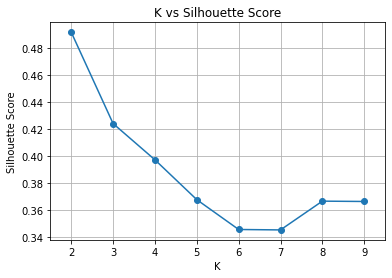

Optimal Silhouette Score occurs at k = 2, with a value of approximately 0.49


In [117]:
# Initialize storage for optimal K and Score
optK = -1
optScore = -2
kList = []
kScore = []

# Get K-Means for K = k and its Silhouette Score
for k in range(2,10):
    
    # K-Means Calculations
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(principalDf)
    labels = kmeans.predict(principalDf)
    
    
    # Get Silhouette Score
    score = silhouette_score(principalDf, labels)
    
    # Replace Optimal if score is larger (and thus closer to the wanted 1 value)
    if (score >= optScore):
        optK = k
        optScore = score
    kList.append(k)
    kScore.append(score)

# Plot Ks vs Scores for visual confirmation of Optimal K
plt.plot(kList, kScore, marker='o')
plt.title('K vs Silhouette Score')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.xlim([kList[0] -0.5, kList[-1] + 0.5])
plt.grid()
plt.show()
print(f"Optimal Silhouette Score occurs at k = {optK}, with a value of approximately {optScore:.2f}")

### Summary and Discussion


With the known data of what the PCA illustrates, it is now time to cluster the data and determine the categorization of the image data into classes or groups. In K-Means, clustering can occur with any k >= 2. In our case, we tested all K values between 2 and 9 to determine the optimal cluster number. Any k > 9 was automatically removed, as the data is not separated into more than 9 groups. We can see this is confirmed in our K-Means graph.

The Silhouette Score is a Score between [-1,1] of the clustering. An optimal clustering would return a score of 1 which means the clusters are well defined, while the worst possible clustering would return -1 there is some mismatch. Values near 0 indicate overlapping. As seen above, k = 2 gives a score of ~0.49, and this is our optimal scoring. 

This signifies that there are 2 groupings for the data and that the data is decently clustered, but may have some overlap. This will indeed be confirmed below.

____

## Part 3. Cluster Interpretation.
Coding help for coloring [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html) and [here](https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option)

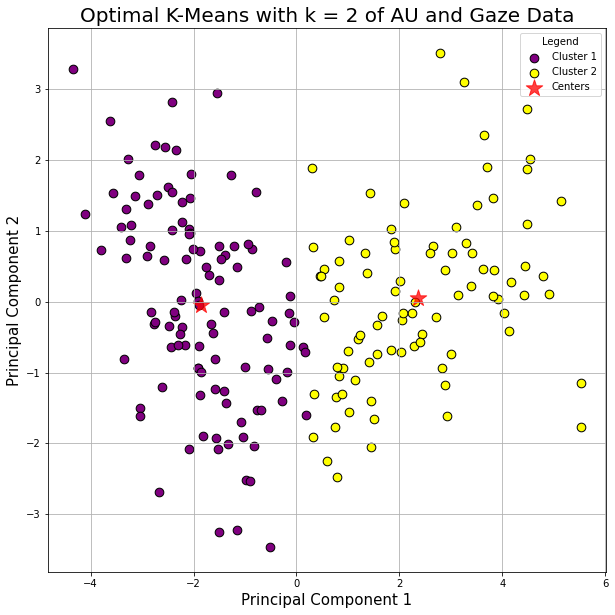

In [118]:
    # Get K-Means for optimal k
    kmeans = KMeans(n_clusters=optK)
    kmeans.fit(principalDf)
    labels = kmeans.predict(principalDf)

    # Set up 9 colors as K can be 2 - 9
    colors = np.array(["purple", "yellow", "green", "pink", "cyan", "orange", "slategrey", "dodgerblue", "lime"])

    # Plot Axis
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot() 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(f'Optimal K-Means with k = {optK} of AU and Gaze Data', fontsize = 20)
    
    # Plot points into Scatter Graph
    for labelName in np.unique(labels):
        indices = np.where(labels == labelName)
        ax.scatter(principalDf.loc[indices,'principal component 1'], 
               principalDf.loc[indices,'principal component 2'], 
               c=colors[labelName], s=75, edgecolors= "black", label=f"Cluster {labelName+1}")
    
    # Plot Centers
    centers = kmeans.cluster_centers_
    centerData = ax.scatter(centers[:, 0], centers[:, 1], s=300, marker='*', c="red", alpha=0.75, edgecolors= "red", label="Centers")
    
    # Add Legend and Grid for clarity
    plt.legend(title="Legend")
    ax.grid()

### Summary and Discussion


With the known data of what the PCA illustrates, it is now time to cluster the data and determine the categorization of the image data into classes or groups. In K-Means, clustering can occur with any k >= 2. In our case, we tested all K values between 2 and 9 to determine the optimal cluster number. Any k > 9 was automatically removed, as the data is not separated into more than 9 groups. We can see this is confirmed in our K-Means graph.
From clustering the data using the optimal k value, we find that there are 2 clusters and that they seem to be heavily focused on Principal Component 1's value. Cluster 1 has points with a positive value for PC1, while Cluster 2 has points with primarily negative PC1 values. Both centers of the clusters also sit very closely on PC2 = 0, meaning that the clustering had little influence from PC2.

As discussed in-depth above, PC1 is determining the amount someone is smiling, with a higher value being a sharper or more prominent smile, whilst a lower value indicates less of a smile, in terms of the corners of one's lips—generally due to the rounding of the mouth. By investigating the large dataset manually, it is also clear there are only 2 types of emotions being depicted. From these two details, we can rename the clusters to give them better, more applicable names:

* Cluster 1, the purple cluster --> Shock/Surprise

People in the Shock Cluster have rounded mouths as seen in AU26 (Jaw Drop), and AU05 (Upper Lid Raiser) is common. Several instances involve hands coming up to one's face, which helps identify the emotion as Shock or Surprise rather than Fear. The eyes are also visibly wider, with eyebrows raised like AU01 (Inner Brow Raiser) and AU02 (Outer Brow Raiser). They are showing prototypical signals of Surprise, hence the cluster name.

* Cluster 2, the yellow cluster --> Happy

People in the Happy Cluster are smiling, and depict the following action units for the most part: AU06 (Cheek Raiser), AU12 (Lip Corner Puller). Some smiles are forced and thus have slight emergence of AU14 (Dimpler) and AU10 (Upper Lip Raiser). They are showing prototypical signals of happiness, hence the cluster name.

We can confirm this by examining some images and finding their corresponding points. Some have been added below.

**Cluster 1: Shock/Surprise Examples**
<br>

<figure>
    <img src='images/Training_2646123.jpg' align= "left" alt='missing' width=100/>
    <br><br><br><br><br>
    <figcaption align= "center">Coordinates: (-1.547626, 2.945402)</figcaption>
</figure>

<br>

<figure>
    <img src='images/Training_2929493.jpg' align= "left" alt='missing' width=100/>
    <br><br><br><br><br>
    <figcaption align= "center">Coordinates: (-0.896411, -2.525706)</figcaption>
</figure>

<br>

<figure>
    <img src='images/Training_598323.jpg' align= "left" alt='missing' width=100/>
    <br><br><br><br><br>
    <figcaption align= "center">Coordinates: (-2.438301, -0.638131</figcaption>
</figure>

**Cluster 2: Happy/Smiling Examples**

<figure>
    <img src='images/Training_1596849.jpg' align= "left" alt='missing' width=100/>
    <br><br><br><br><br>
    <figcaption align= "center">Coordinates: (1.501878, -1.650714)</figcaption>
</figure>

<br>

<figure>
    <img src='images/Training_185749.jpg' align= "left" alt='missing' width=100/>
    <br><br><br><br><br>
    <figcaption align= "center">Coordinates: (3.143470, 0.094614)</figcaption>
</figure>

<br>

<figure>
    <img src='images/Training_512121.jpg' align= "left" alt='missing' width=100/>
    <br><br><br><br><br>
    <figcaption align= "center">Coordinates: (1.418922, 1.530028)</figcaption>
</figure>

___

As a final note, it is important to realize much of this data comes from OpenFace, an API meant to identify AUs from images. However, nowhere in the documentation does it mention the behaviour of the API when given images that are blurry, or have items blocking one's face such as hands or even watermarks. There are some images in the database that are like this, and this may have muddled the data. This is simply a limitation of the technology used. The tech could even determine one's eye size inaccurately due to blurriness or simple technical error, which may once again also muddy the data analysis presented in this notebook.